# Imports

In [44]:
import pandas as pd
import numpy as np
import subprocess
import time
from time import sleep
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.utils import io

# For ROC plots
from matplotlib import patches
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Function Definitions

In [22]:
max_threads = 20

#grids = {}

# Grid search parameter options
num_trees = [100, 200]
max_depth = [10, 15, 30, 80]
min_cases = [7, 10, 15, 20, 25, 30, 35, 40]# [5, 7, 10, 12, 15, 17, 20, 22, 25, 27, 30, 35, 40, 70, 90]

def cleanup():
    ! rm -f *predictions.csv *metrics.csv *attributes.csv

# Run the entire model process
def run_model(fn): 
    
    cleanup()
    describe(fn)
    gs = grid_search(fn)
#     with io.capture_output():
#         rf(fn=fn, op='', conc=2, nt=gs['num_trees'], md=gs['max_depth'], mc=gs['min_cases'])
    print("Random Forest Model LOPO CV Results\n--")
    roc_auc(gs['output_prefix'])
    cleanup()

# Describe dataset
def describe(fn):
    
    df = pd.read_csv(fn)
    label_arity = df.value_counts('label')
    print(f"Dataset\n--\nSamples (n): {df.shape[0]}\nFeatures (m): {df.columns.shape[0]-2}\n")
    print(f"Label Arity\n--\nArtifact: {label_arity.loc[0]}\nReal: {label_arity.loc[1]}\n")
    print(f"Patients\n--\nNumber of patients: {df['filename'].unique().shape[0]}\nSamples per patient: mean {round(df.value_counts('filename').mean(), 2)}, variance {round(df.value_counts('filename').var(), 2)}\n")

# Run Auton's random forest on a file
# fn=filename, op=output prefix, conc=num threads, nt=num trees, md=max depth, mc=min cases
# TODO: remove conc, no longer used
def rf(fn, op, conc, nt, md, mc, wait=True):
    
    ! rm -f {op}predictions.csv {op}attributes.csv {op}metrics.csv {op}A*.csv
    
    #! ../../C/random_forest/random_forest ds ../../ppinnc/featurization/{fn} label label valAttnum filename output_prefix {op} num_threads {conc} iter {nt} min_cases {mc} depth {md}
    p = subprocess.Popen(
        f"../../C/random_forest/random_forest ds ../../ppinnc/featurization/{fn} label label valAttnum filename {('output_prefix '+op) if op else ''} iter {nt} min_cases {mc} depth {md}",
        shell=True,
        #stderr=subprocess.PIPE,
        #stdout=subprocess.PIPE
    )
    
    if wait:
        p.wait()
        
    return p

def grid_search(fn):

    global max_threads, grids, num_trees, max_depth, min_cases
    
    start = time.time()
    
    printout = False

    def wait(p):
        printout and print("Waiting", end='... ')
        p.wait()
        #stdout, stderr = p.communicate()
        #comms.append((stdout, stderr))
        #print(stdout.decode("utf-8"), stderr.decode("utf-8"), sep="\n")
        printout and print("Done.")

    comms = []
    waitForThese = []
    num_possibilities = len(num_trees) * len(max_depth) * len(min_cases)
    i = 1
    grid = []

    for nt in num_trees:
        for md in max_depth:
            for mc in min_cases:

                if len(waitForThese) >= max_threads:
                    wait(waitForThese.pop(0))

                printout and print(f"\n\n\n{i} of {num_possibilities}\n--")
                waitForThese.append(rf(fn=fn, op=str(i), conc=2, nt=nt, md=md, mc=mc, wait=False))

                i += 1

    # Wait for the remaining processes
    while len(waitForThese) > 0:
        wait(waitForThese.pop(0))

    printout and print("All grid-search models have returned.\n")

    i = 1
    printout and print("Assembling results.")
    for nt in num_trees:
        for md in max_depth:
            for mc in min_cases:
                printout and print(f"{i}", end='... ')
                grid.append([str(i), nt, md, mc, get_auc(str(i))])
                printout and print("Done.")
                i += 1

    grid = pd.DataFrame(grid, columns=['output_prefix', 'num_trees', 'max_depth', 'min_cases', 'auc'])

    # Add to the global grids
    grids[fn] = grid
    
    winner = grid.sort_values('auc').iloc[-1]
    
    print(
        f"Grid Search\n--\n"+
        f"Tried: {num_possibilities} combinations\n"+
        f"Time: {round(time.time()-start, 0):.0f} seconds\n"+
        f"Best params: num_trees={winner['num_trees']}, max_depth={winner['max_depth']}, min_cases={winner['min_cases']}\n"+
        f"Grid search AUC: {round(winner['auc'], 4)}\n"
    )

    return winner

# Output AUC and ROC graphs
# op=output prefix
def roc_auc(op=''):
    
    print("AUC:", round(get_auc(op), 4))
    three_roc_plot(op)

# Compute & return the AUC
# op=output prefix
def get_auc(op=''):

    ! sed -i "1s/.*/A0,A1,true_output/" {op}predictions.csv
    pred = pd.read_csv(op+'predictions.csv')
    return roc_auc_score(pred['true_output'], pred['A1'])
    
# Plot the three ROC graphs
# op=output prefix
def three_roc_plot(op=''):

    ! sed -i "1s/.*/A0,A1,true_output/" {op}predictions.csv
    
    with io.capture_output():
        
        ! ./random_forest_roc option roc ds {op}predictions.csv

#         ! python 2class_process_roc_stds.py {op}A1_roc
#         ! python 2class_process_roc_stds.py {op}A2_roc
        ! python 2class_process_roc_stds.py A1_roc
        ! python 2class_process_roc_stds.py A2_roc

    ## three roc curves in one plot

    ## ROC curves of a random classifier, for reference
    RANDOM_FP = np.arange(0, 1., 0.01)
    RANDOM_TP = np.arange(0, 1., 0.01)
    RANDOM_FP[0] = 1e-4
    RANDOM_TP[0] = 1e-4

    ## Mean and confidence bands of FPR V.S. TPR curve
#     a1 = pd.read_csv('./'+op+'A1_roc_std.csv')
    a1 = pd.read_csv('./A1_roc_std.csv')
    conf_UB = a1[['FP1UB', 'TP1UB']].copy()
    conf_UB.columns = ['X', 'Y']
    conf_LB = a1[['FP1LB', 'TP1LB']].iloc[range(a1.shape[0]-1, -1, -1)]
    conf_LB.columns = ['X', 'Y']
    conf = pd.concat((conf_UB, conf_LB))

    fig = plt.figure(figsize=(15, 4))

    ## FPR V.S. TPR curve
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(a1['FP1'], a1['TP1'], color='C1')
    poly = Polygon(list(zip(conf['X'], conf['Y'])))
    poly = PolygonPatch(poly, linewidth=0, fc='C1', alpha=0.4)
    ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FPR', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.ylabel('TPR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')

    ## FPR (log-scale) V.S. TPR curve
    ax = fig.add_subplot(1, 3, 2)  
    plt.plot(a1['FP1'], a1['TP1'], color='C1') 
    poly = Polygon(list(zip(conf['X'], conf['Y'])))
    poly = PolygonPatch(poly, linewidth=0, fc='C1', alpha=0.4)
    ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FPR', fontsize=14)
    plt.xscale('log',base=10) 
    plt.xlim(0.6*1e-4, 1.6)
    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1.0], ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1.0'])
    plt.ylabel('TPR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')
    plt.title('ROC curves', fontsize=15, pad=10)

    ## here A2 treats the 2nd class 'usa' as positive and the 1st class 'asia' as negative 
    a2 = pd.read_csv('./A2_roc_std.csv')
    conf_UB = a2[['FP1UB', 'TP1UB']].copy()
    conf_UB.columns = ['X', 'Y']
    conf_LB = a2[['FP1LB', 'TP1LB']].iloc[range(a2.shape[0]-1, -1, -1)]
    conf_LB.columns = ['X', 'Y']
    conf = pd.concat((conf_UB, conf_LB))

    ax = fig.add_subplot(1, 3, 3) 
    plt.plot(a2['FP1'], a2['TP1'], color='C0') 
    poly = Polygon(list(zip(conf['X'], conf['Y'])))
    poly = PolygonPatch(poly, linewidth=0, fc='C0', alpha=0.4)
    ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FNR', fontsize=14)
    plt.xscale('log',base=10) 
    plt.xlim(0.6*1e-4, 1.6)
    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1.0], ['$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1.0'])
    plt.ylabel('TNR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')

    plt.subplots_adjust(wspace=0.4)
    plt.show()

# Grid Search

# Baseline Model (Numerics @ 1/20Hz, No Art BP)

## HR

Dataset
--
Samples (n): 182
Features (m): 205

Label Arity
--
Artifact: 6
Real: 176

Patients
--
Number of patients: 44
Samples per patient: mean 4.14, variance 3.52

Grid Search
--
Tried: 90 combinations
Time: 243 seconds
Best params: num_trees=100, max_depth=15, min_cases=10
Grid search AUC: 0.9631

Random Forest Model LOPO CV Results
--
AUC: 0.9631


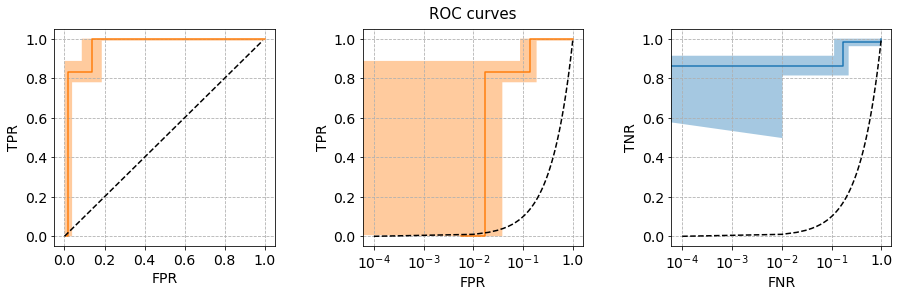

In [14]:
run_model('data_hr_withfn_p1.csv')

## RR

Dataset
--
Samples (n): 191
Features (m): 205

Label Arity
--
Artifact: 49
Real: 142

Patients
--
Number of patients: 26
Samples per patient: mean 7.35, variance 11.44

Grid Search
--
Tried: 90 combinations
Time: 175 seconds
Best params: num_trees=100, max_depth=80, min_cases=10
Grid search AUC: 0.9057

Random Forest Model LOPO CV Results
--
AUC: 0.9057


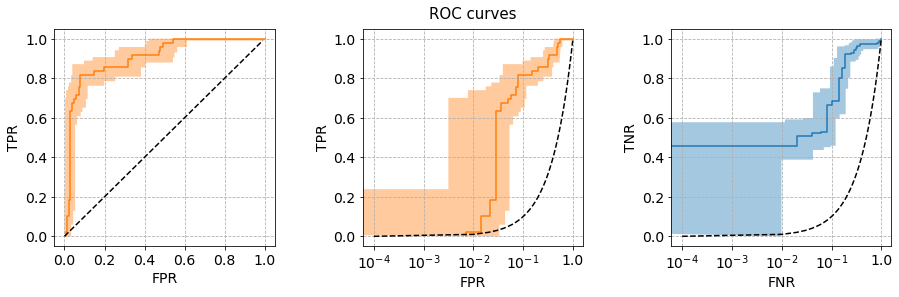

In [16]:
run_model('data_rr_withfn_p1.csv')

## SpO2

Dataset
--
Samples (n): 196
Features (m): 205

Label Arity
--
Artifact: 59
Real: 137

Patients
--
Number of patients: 32
Samples per patient: mean 6.12, variance 11.98

Grid Search
--
Tried: 64 combinations
Time: 131 seconds
Best params: num_trees=200, max_depth=15, min_cases=35
Grid search AUC: 0.8854

Random Forest Model LOPO CV Results
--
AUC: 0.8854


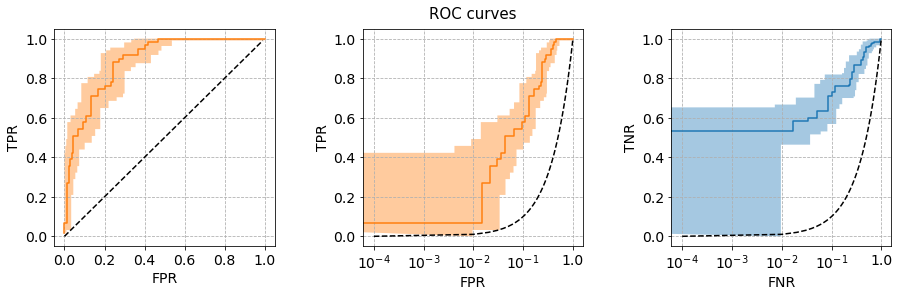

In [23]:
run_model('data_spo2_withfn_p1.csv')

# Model 1 (Numerics @ 1Hz, No Art BP)

## HR

Dataset
--
Samples (n): 185
Features (m): 205

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 119 seconds
Best params: num_trees=200, max_depth=10, min_cases=25
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


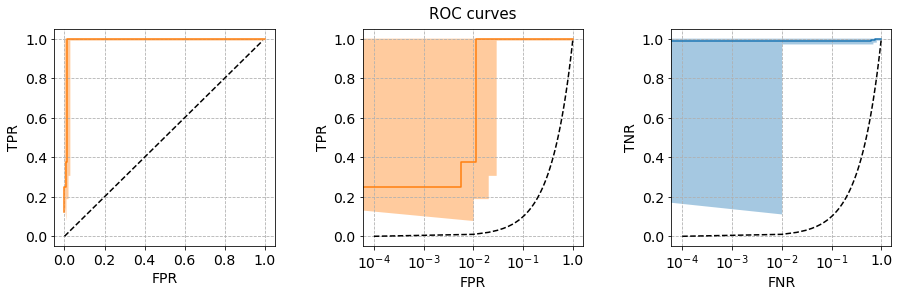

In [24]:
run_model('data_hr_withfn_noabp.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 205

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 111 seconds
Best params: num_trees=200, max_depth=30, min_cases=15
Grid search AUC: 0.9241

Random Forest Model LOPO CV Results
--
AUC: 0.9241


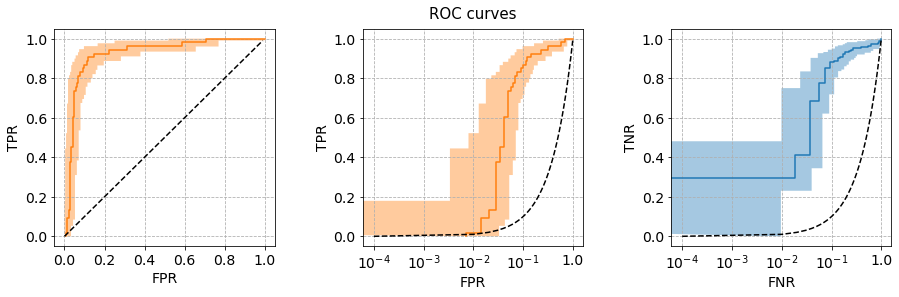

In [25]:
run_model('data_rr_withfn_noabp.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 205

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 160 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9183

Random Forest Model LOPO CV Results
--
AUC: 0.9183


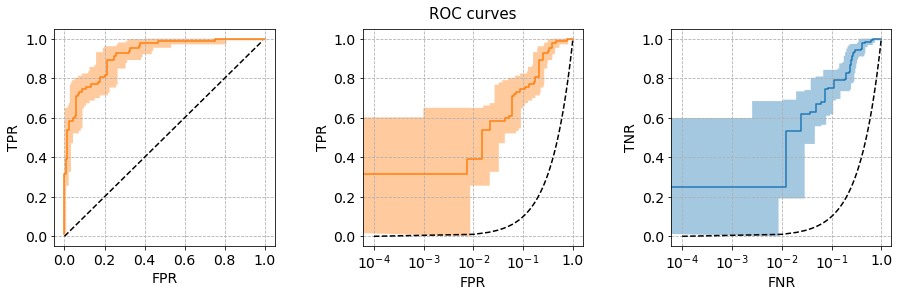

In [26]:
run_model('data_spo2_withfn_noabp.csv')

# Model 2 (Numerics @ 1Hz, w/ Art BP when avail)

## HR

Dataset
--
Samples (n): 185
Features (m): 287

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 172 seconds
Best params: num_trees=100, max_depth=80, min_cases=40
Grid search AUC: 0.9915

Random Forest Model LOPO CV Results
--
AUC: 0.9915


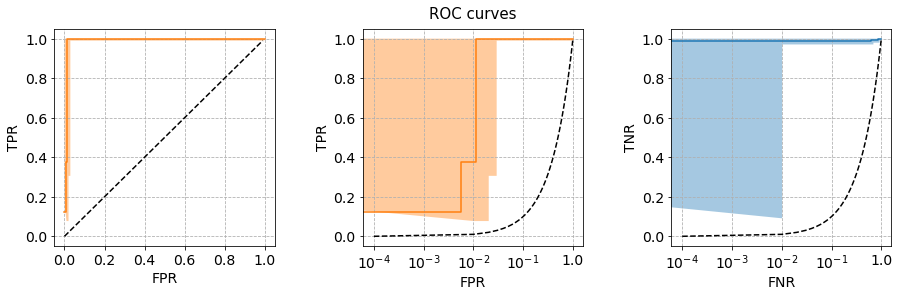

In [27]:
run_model('data_hr_withfn.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 287

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 167 seconds
Best params: num_trees=200, max_depth=15, min_cases=20
Grid search AUC: 0.9293

Random Forest Model LOPO CV Results
--
AUC: 0.9293


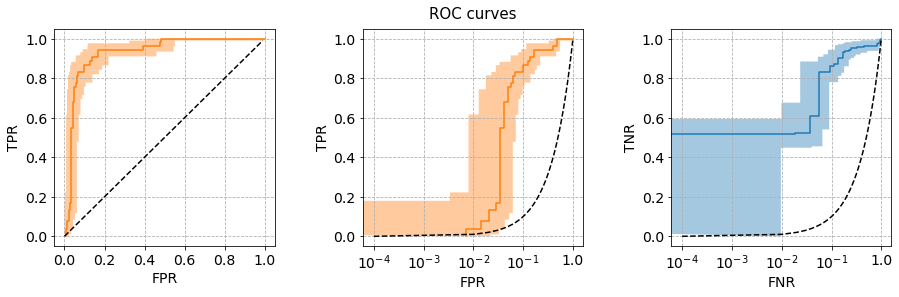

In [28]:
run_model('data_rr_withfn.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 287

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 225 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9202

Random Forest Model LOPO CV Results
--
AUC: 0.9202


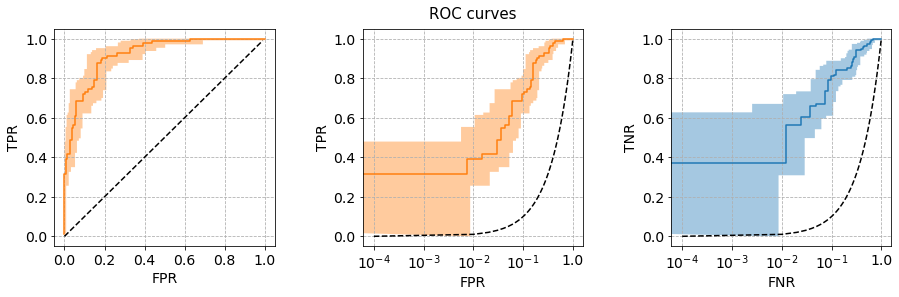

In [29]:
run_model('data_spo2_withfn.csv')

# Model 3a (Numerics @ 1Hz, No Art BP, Pleth Features @ 3s rw)

## HR

Dataset
--
Samples (n): 185
Features (m): 228

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 140 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


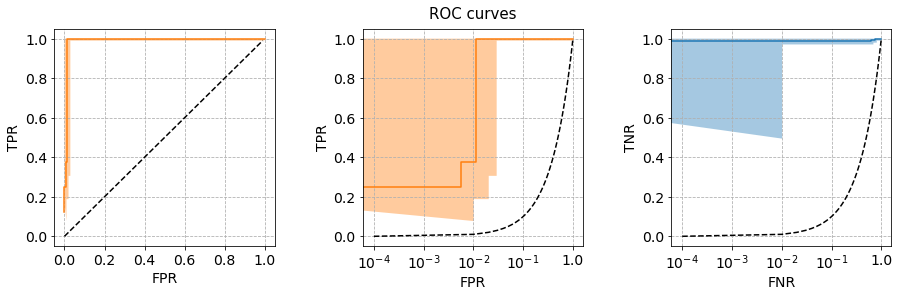

In [30]:
run_model('data_hr_withfn_pleth2.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 228

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 130 seconds
Best params: num_trees=200, max_depth=30, min_cases=7
Grid search AUC: 0.9284

Random Forest Model LOPO CV Results
--
AUC: 0.9284


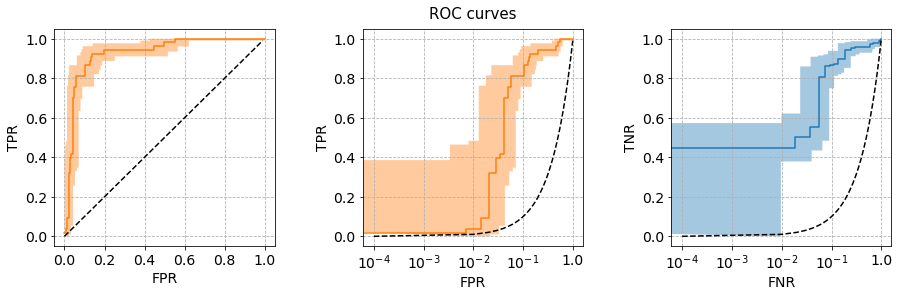

In [31]:
run_model('data_rr_withfn_pleth2.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 228

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 177 seconds
Best params: num_trees=200, max_depth=15, min_cases=7
Grid search AUC: 0.9329

Random Forest Model LOPO CV Results
--
AUC: 0.9329


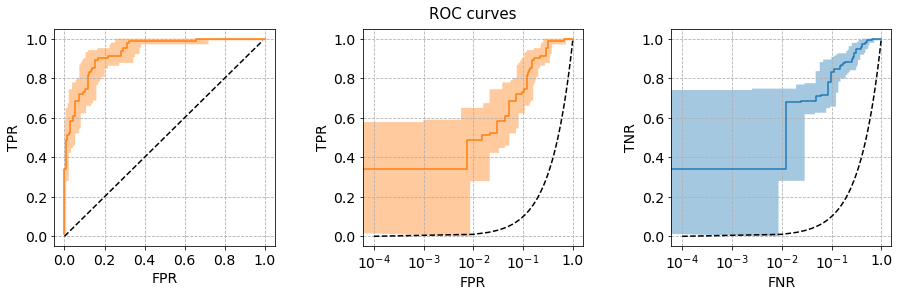

In [32]:
run_model('data_spo2_withfn_pleth2.csv')

# Model 3b (Numerics @ 1Hz, No Art BP, Pleth Features @ 10s rw)

## HR

Dataset
--
Samples (n): 185
Features (m): 228

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 139 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


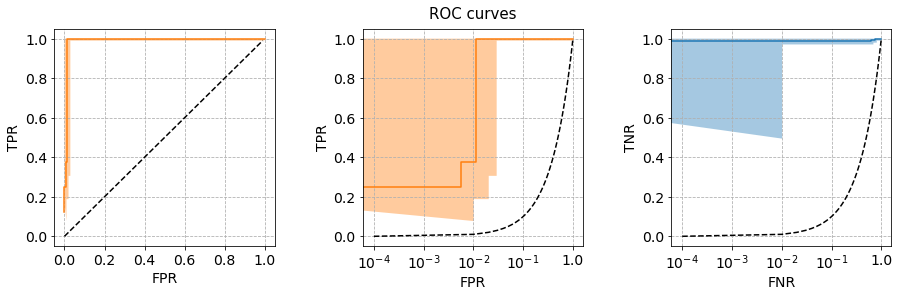

In [33]:
run_model('data_hr_withfn_pleth3.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 228

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 129 seconds
Best params: num_trees=200, max_depth=10, min_cases=30
Grid search AUC: 0.9282

Random Forest Model LOPO CV Results
--
AUC: 0.9282


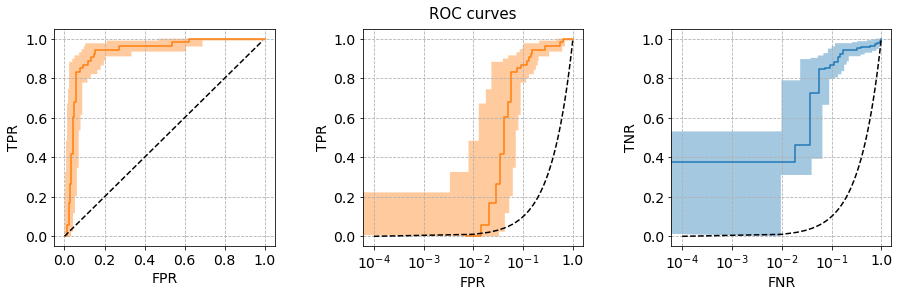

In [34]:
run_model('data_rr_withfn_pleth3.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 228

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 176 seconds
Best params: num_trees=200, max_depth=80, min_cases=20
Grid search AUC: 0.9289

Random Forest Model LOPO CV Results
--
AUC: 0.9289


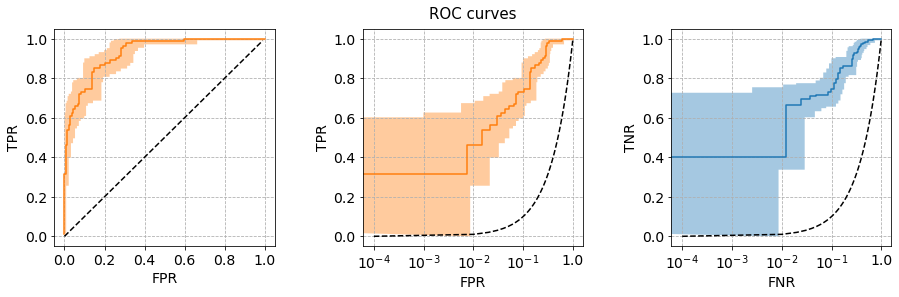

In [35]:
run_model('data_spo2_withfn_pleth3.csv')

# Model 3c (Numerics @ 1Hz, No Art BP, Pleth Features @ 15s rw)

## HR

Dataset
--
Samples (n): 185
Features (m): 228

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 139 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


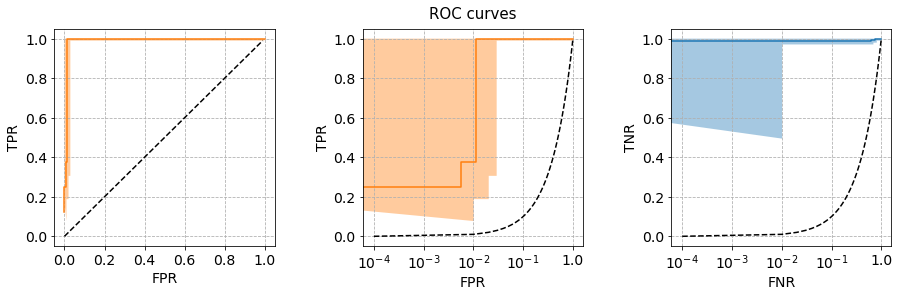

In [36]:
run_model('data_hr_withfn_pleth15s.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 228

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 129 seconds
Best params: num_trees=200, max_depth=10, min_cases=30
Grid search AUC: 0.9282

Random Forest Model LOPO CV Results
--
AUC: 0.9282


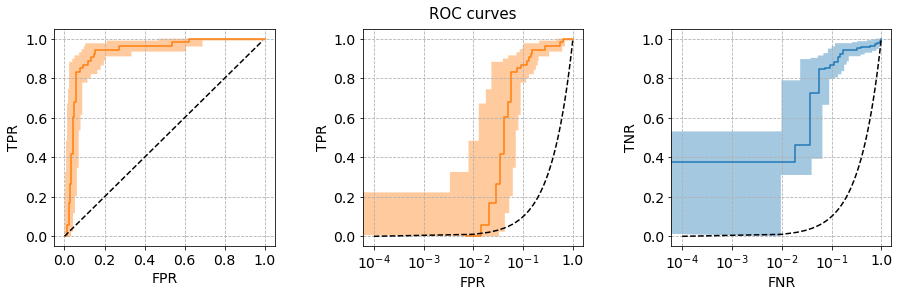

In [37]:
run_model('data_rr_withfn_pleth15s.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 228

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 178 seconds
Best params: num_trees=200, max_depth=80, min_cases=20
Grid search AUC: 0.9289

Random Forest Model LOPO CV Results
--
AUC: 0.9289


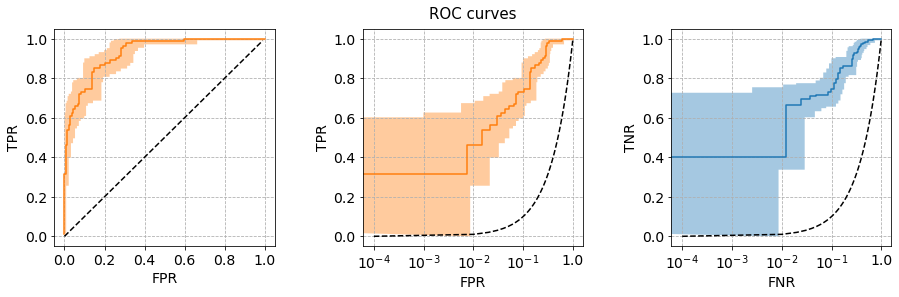

In [38]:
run_model('data_spo2_withfn_pleth15s.csv')

# Model 3d (Numerics @ 1Hz, No Art BP, Pleth Features @ 20s rw)

## HR

Dataset
--
Samples (n): 185
Features (m): 228

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 206 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


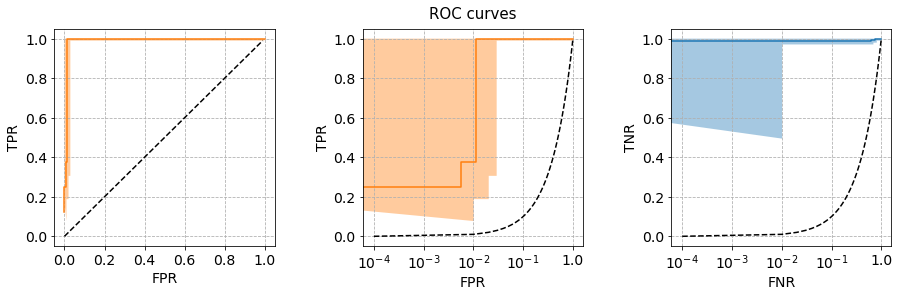

In [40]:
run_model('data_hr_withfn_pleth20s.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 228

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 188 seconds
Best params: num_trees=200, max_depth=80, min_cases=30
Grid search AUC: 0.9282

Random Forest Model LOPO CV Results
--
AUC: 0.9282


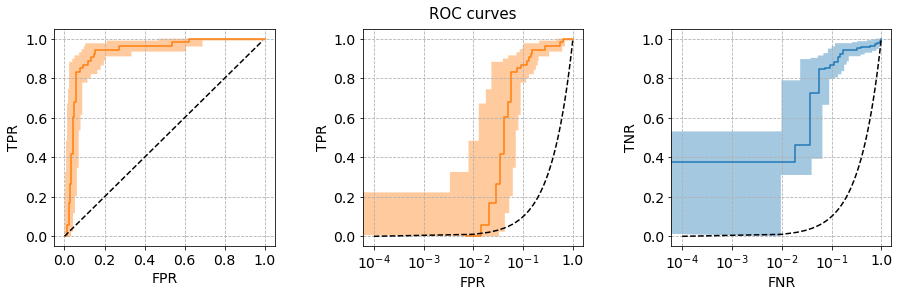

In [41]:
run_model('data_rr_withfn_pleth20s.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 228

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 260 seconds
Best params: num_trees=100, max_depth=30, min_cases=7
Grid search AUC: 0.9283

Random Forest Model LOPO CV Results
--
AUC: 0.9283


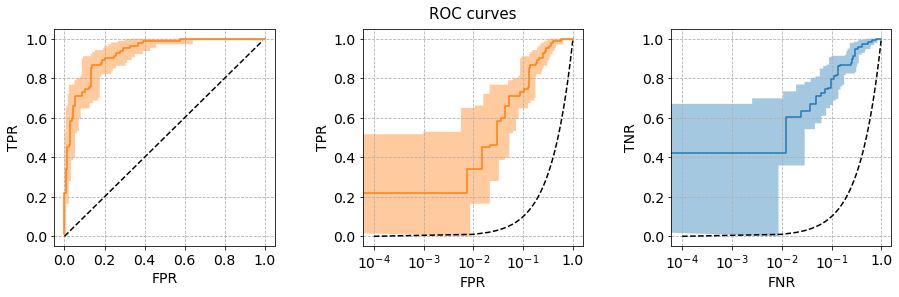

In [42]:
run_model('data_spo2_withfn_pleth20s.csv')

# Model 3e (Numerics @ 1Hz, No Art BP, Pleth Features @ 3s rw, HR/RR Stats, SNR)

## HR

Dataset
--
Samples (n): 185
Features (m): 239

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 130 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


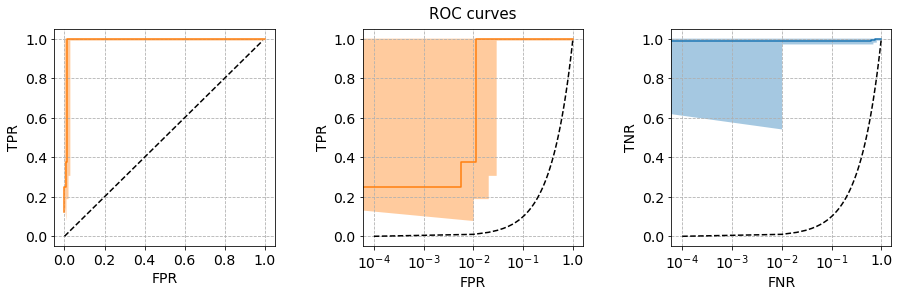

In [45]:
run_model('data_hr_withfn_pleth3s_ecgsnr_hrrr.csv')

## RR

Dataset
--
Samples (n): 196
Features (m): 239

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 118 seconds
Best params: num_trees=100, max_depth=30, min_cases=20
Grid search AUC: 0.9295

Random Forest Model LOPO CV Results
--
AUC: 0.9295


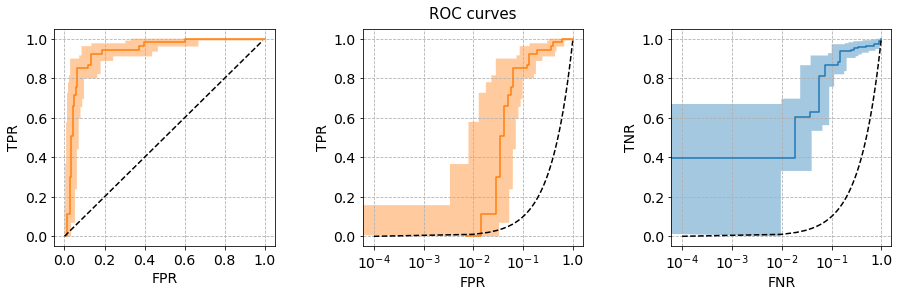

In [46]:
run_model('data_rr_withfn_pleth3s_ecgsnr_hrrr.csv')

## SpO2

Dataset
--
Samples (n): 219
Features (m): 239

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 163 seconds
Best params: num_trees=200, max_depth=15, min_cases=20
Grid search AUC: 0.9283

Random Forest Model LOPO CV Results
--
AUC: 0.9283


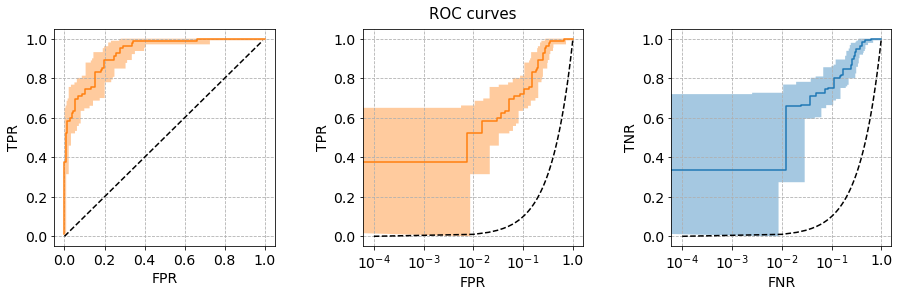

In [47]:
run_model('data_spo2_withfn_pleth3s_ecgsnr_hrrr.csv')

# Scratch/Other

# Scratch Try \#1 (same as Model 3e, but basic stats for pleth & ecgii removed)

Dataset
--
Samples (n): 185
Features (m): 219

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 117 seconds
Best params: num_trees=200, max_depth=30, min_cases=25
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


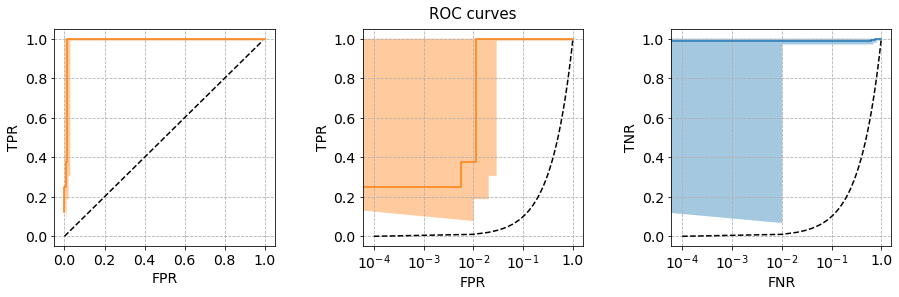

In [49]:
run_model('data_hr_withfn_try1.csv')

Dataset
--
Samples (n): 196
Features (m): 219

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 106 seconds
Best params: num_trees=100, max_depth=10, min_cases=7
Grid search AUC: 0.9326

Random Forest Model LOPO CV Results
--
AUC: 0.9326


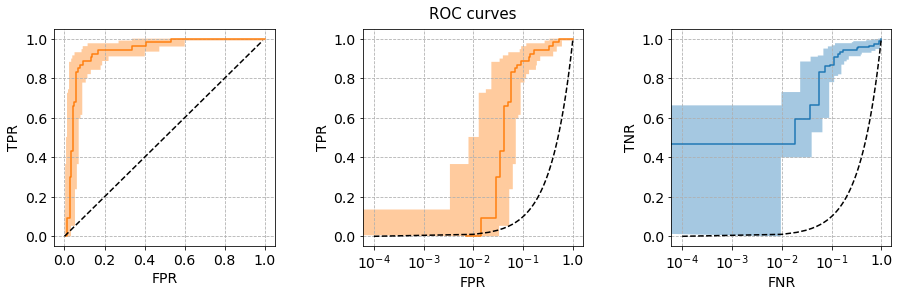

In [50]:
run_model('data_rr_withfn_try1.csv')

Dataset
--
Samples (n): 219
Features (m): 219

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 149 seconds
Best params: num_trees=100, max_depth=30, min_cases=7
Grid search AUC: 0.925

Random Forest Model LOPO CV Results
--
AUC: 0.925


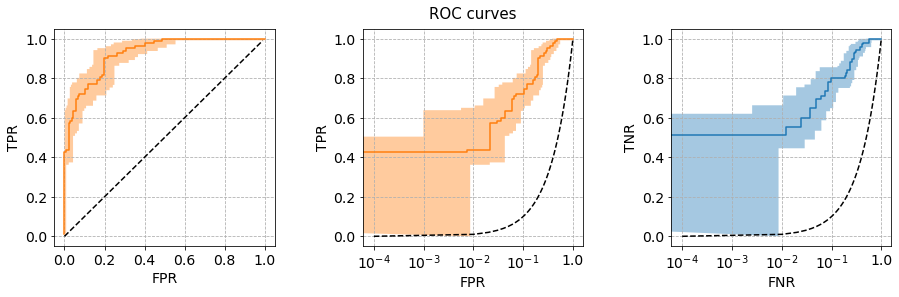

In [51]:
run_model('data_spo2_withfn_try1.csv')

# Scratch Try \#2 (same as Model 3e, but basic stats for pleth & ecgii and NBP removed)

Dataset
--
Samples (n): 185
Features (m): 137

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

Grid Search
--
Tried: 64 combinations
Time: 115 seconds
Best params: num_trees=200, max_depth=10, min_cases=7
Grid search AUC: 0.9922

Random Forest Model LOPO CV Results
--
AUC: 0.9922


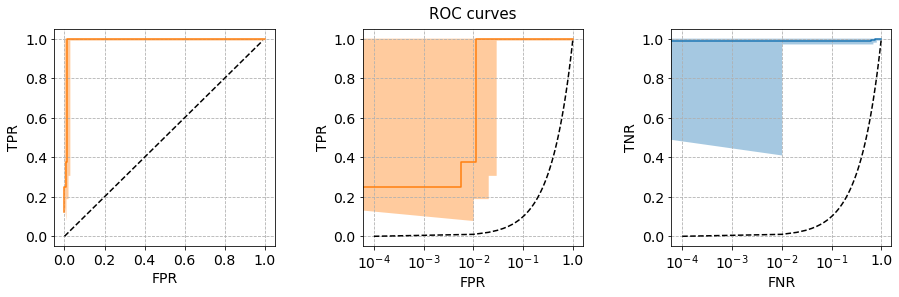

In [52]:
run_model('data_hr_withfn_try2.csv')

Dataset
--
Samples (n): 196
Features (m): 137

Label Arity
--
Artifact: 53
Real: 143

Patients
--
Number of patients: 28
Samples per patient: mean 7.0, variance 12.15

Grid Search
--
Tried: 64 combinations
Time: 103 seconds
Best params: num_trees=200, max_depth=15, min_cases=7
Grid search AUC: 0.9357

Random Forest Model LOPO CV Results
--
AUC: 0.9357


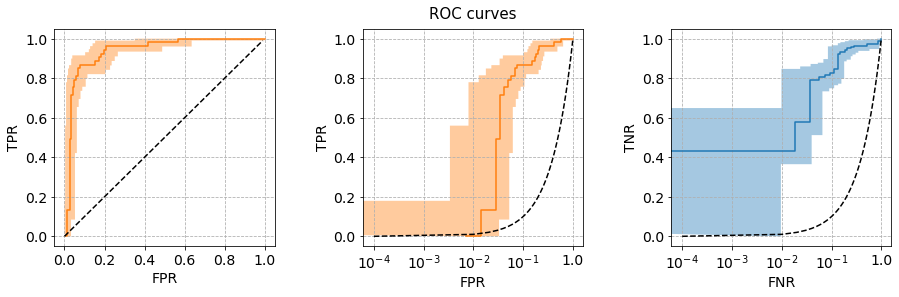

In [53]:
run_model('data_rr_withfn_try2.csv')

Dataset
--
Samples (n): 219
Features (m): 137

Label Arity
--
Artifact: 82
Real: 137

Patients
--
Number of patients: 33
Samples per patient: mean 6.64, variance 16.18

Grid Search
--
Tried: 64 combinations
Time: 148 seconds
Best params: num_trees=200, max_depth=15, min_cases=7
Grid search AUC: 0.9305

Random Forest Model LOPO CV Results
--
AUC: 0.9305


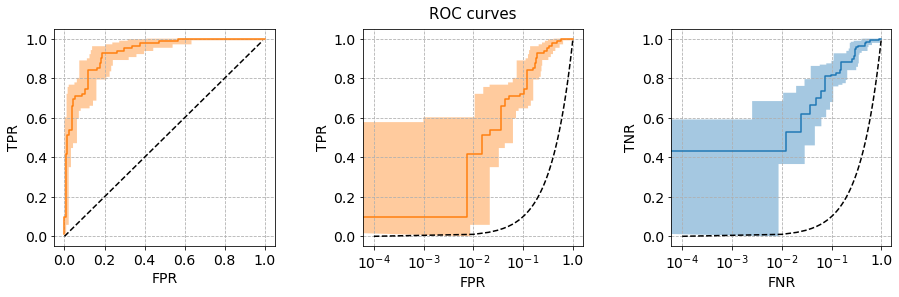

In [54]:
run_model('data_spo2_withfn_try2.csv')

Heart Rate (HR)
---------------

Baseline

Dataset
--
Samples (n): 182
Features (m): 205

Label Arity
--
Artifact: 6
Real: 176

Patients
--
Number of patients: 44
Samples per patient: mean 4.14, variance 3.52

AUC
--
0.9630681818181818


Model 1

Dataset
--
Samples (n): 185
Features (m): 205

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

AUC
--
0.9922316384180792


Model 3e

Dataset
--
Samples (n): 185
Features (m): 239

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

AUC
--
0.992231638418079


Model 3a

Dataset
--
Samples (n): 185
Features (m): 228

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient: mean 4.2, variance 3.65

AUC
--
0.992231638418079


Model Try #2

Dataset
--
Samples (n): 185
Features (m): 137

Label Arity
--
Artifact: 8
Real: 177

Patients
--
Number of patients: 44
Samples per patient

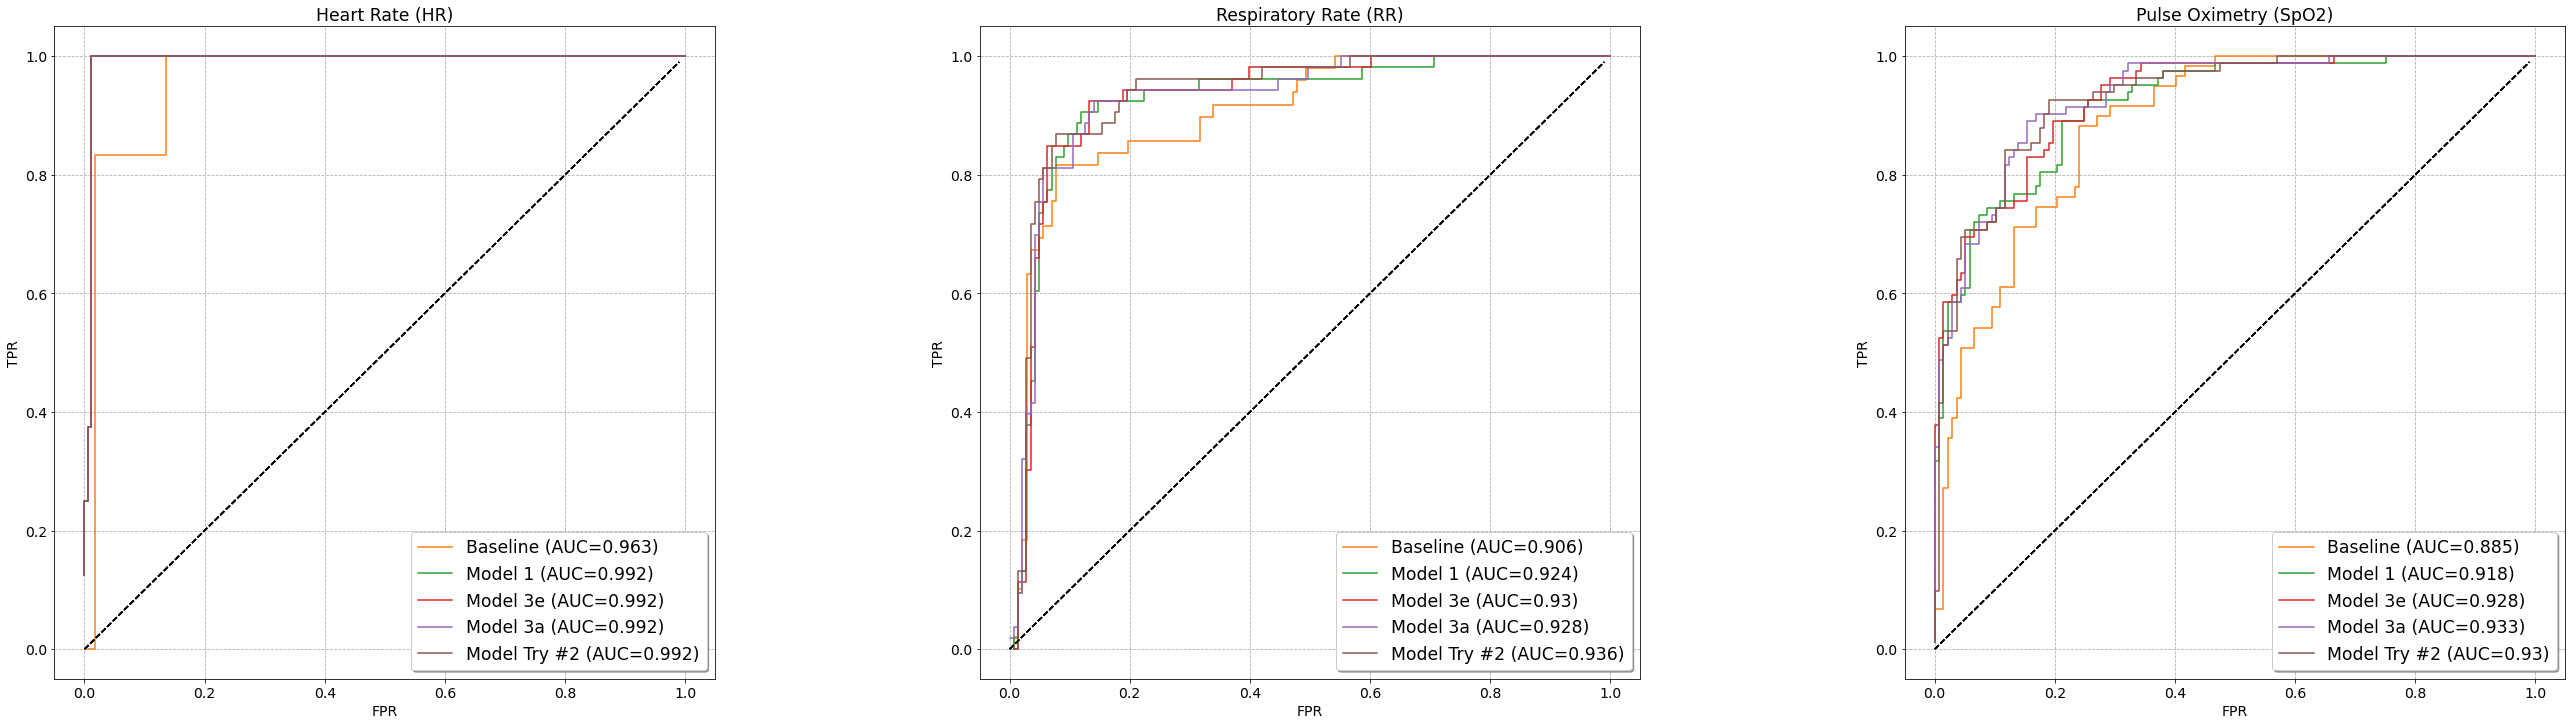

In [75]:
def combined_plot(fig, ax, name, color):
    
    # throwaway
    op = ''

    ! sed -i "1s/.*/A0,A1,true_output/" {op}predictions.csv
    
    with io.capture_output():
        
        ! ./random_forest_roc option roc ds {op}predictions.csv

#         ! python 2class_process_roc_stds.py {op}A1_roc
#         ! python 2class_process_roc_stds.py {op}A2_roc
        ! python 2class_process_roc_stds.py A1_roc
        ! python 2class_process_roc_stds.py A2_roc

    ## three roc curves in one plot

    ## ROC curves of a random classifier, for reference
    RANDOM_FP = np.arange(0, 1., 0.01)
    RANDOM_TP = np.arange(0, 1., 0.01)
    RANDOM_FP[0] = 1e-4
    RANDOM_TP[0] = 1e-4

    ## Mean and confidence bands of FPR V.S. TPR curve
#     a1 = pd.read_csv('./'+op+'A1_roc_std.csv')
    a1 = pd.read_csv('./A1_roc_std.csv')
    conf_UB = a1[['FP1UB', 'TP1UB']].copy()
    conf_UB.columns = ['X', 'Y']
    conf_LB = a1[['FP1LB', 'TP1LB']].iloc[range(a1.shape[0]-1, -1, -1)]
    conf_LB.columns = ['X', 'Y']
    conf = pd.concat((conf_UB, conf_LB))

    #fig = plt.figure(figsize=(15, 4))

    ## FPR V.S. TPR curve
#     ax = fig.add_subplot(1, 3, 1)
    plt.plot(a1['FP1'], a1['TP1'], color=color, label=name)
#     poly = Polygon(list(zip(conf['X'], conf['Y'])))
#     poly = PolygonPatch(poly, linewidth=0, fc='C1', alpha=0.4)
#     ax.add_patch(poly)
    plt.plot(RANDOM_FP, RANDOM_TP, color='black', linestyle='--')
    plt.xlabel('FPR', fontsize=14)
    plt.xlim(-0.05, 1.05)
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.ylabel('TPR', fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(linestyle='--')

#     plt.subplots_adjust(wspace=0.4)
#     plt.show()

def fornow(fig, ax, name, color, fn, nt, md, mc):
    print(f'{name}\n')
    describe(fn)
    cleanup()
    with io.capture_output():
        rf(fn=fn, op='', conc='', nt=nt, md=md, mc=mc)
    auc = get_auc()
    combined_plot(fig, ax, name+f' (AUC={round(auc,3)})', color)
    print(f'AUC\n--\n{auc}\n\n')
    
#roc_auc(gs['output_prefix'])

fig = plt.figure(figsize=(45, 12))

# fornow(fig, ax, 'Model '?, 'C3', '.csv', nt=, md=, mc=)

print('Heart Rate (HR)\n---------------\n')
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Heart Rate (HR)', fontdict={'fontsize': 'xx-large'})
fornow(fig, ax, 'Baseline', 'C1', 'data_hr_withfn_p1.csv', nt=100, md=15, mc=10)
fornow(fig, ax, 'Model 1', 'C2', 'data_hr_withfn_noabp.csv', nt=200, md=10, mc=25)
# fornow(fig, ax, 'Model 2', 'C3', 'data_hr_withfn_pleth3s_ecgsnr_hrrr.csv', nt=100, md=10, mc=7) # note: Model 3e
fornow(fig, ax, 'Model 3e', 'C3', 'data_hr_withfn_pleth3s_ecgsnr_hrrr.csv', nt=100, md=10, mc=7)
fornow(fig, ax, 'Model 3a', 'C4', 'data_hr_withfn_pleth2.csv', nt=100, md=10, mc=7)
fornow(fig, ax, 'Model Try #2', 'C5', 'data_hr_withfn_try2.csv', nt=200, md=10, mc=7)
ax.legend(loc='lower right', fontsize='xx-large', shadow=True)

print('\n\n\nRespiratory Rate (RR)\n---------------------\n')
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Respiratory Rate (RR)', fontdict={'fontsize': 'xx-large'})
fornow(fig, ax, 'Baseline', 'C1', 'data_rr_withfn_p1.csv', nt=100, md=80, mc=10)
fornow(fig, ax, 'Model 1', 'C2', 'data_rr_withfn_noabp.csv', nt=200, md=30, mc=15)
# fornow(fig, ax, 'Model 2', 'C3', 'data_rr_withfn_pleth3s_ecgsnr_hrrr.csv', nt=100, md=30, mc=20) # note: Model 3e
fornow(fig, ax, 'Model 3e', 'C3', 'data_rr_withfn_pleth3s_ecgsnr_hrrr.csv', nt=100, md=30, mc=20)
fornow(fig, ax, 'Model 3a', 'C4', 'data_rr_withfn_pleth2.csv', nt=200, md=30, mc=7)
fornow(fig, ax, 'Model Try #2', 'C5', 'data_rr_withfn_try2.csv', nt=200, md=15, mc=7)
ax.legend(loc='lower right', fontsize='xx-large', shadow=True)

print('\n\n\nPulse Oximetry (SpO2)\n---------------------\n')
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Pulse Oximetry (SpO2)', fontdict={'fontsize': 'xx-large'})
fornow(fig, ax, 'Baseline', 'C1', 'data_spo2_withfn_p1.csv', nt=200, md=815, mc=35)
fornow(fig, ax, 'Model 1', 'C2', 'data_spo2_withfn_noabp.csv', nt=100, md=10, mc=7)
# fornow(fig, ax, 'Model 2', 'C3', 'data_spo2_withfn_pleth3s_ecgsnr_hrrr.csv', nt=200, md=15, mc=20) # note: Model 3e
fornow(fig, ax, 'Model 3e', 'C3', 'data_spo2_withfn_pleth3s_ecgsnr_hrrr.csv', nt=200, md=15, mc=20)
fornow(fig, ax, 'Model 3a', 'C4', 'data_spo2_withfn_pleth2.csv', nt=200, md=15, mc=7)
fornow(fig, ax, 'Model Try #2', 'C5', 'data_spo2_withfn_try2.csv', nt=200, md=15, mc=7)
ax.legend(loc='lower right', fontsize='xx-large', shadow=True)

print('\n')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
display(grids['data_hr_withfn_p1.csv'].groupby('max_depth').mean())
display(grids['data_rr_withfn_p1.csv'].groupby('max_depth').mean())

display(grids['data_hr_withfn_p1.csv'].groupby('min_cases').mean())
display(grids['data_rr_withfn_p1.csv'].groupby('min_cases').mean())

display(grids['data_hr_withfn_p1.csv'].groupby('num_trees').mean())
display(grids['data_rr_withfn_p1.csv'].groupby('num_trees').mean())

display(grids['data_hr_withfn_p1.csv'].groupby('num_trees').max())
display(grids['data_rr_withfn_p1.csv'].groupby('num_trees').max())

with pd.option_context("display.max_rows", 1000):
    display(grids['data_hr_withfn_p1.csv'].sort_values('auc'))
    
g=grids['data_hr_withfn_p1.csv']
g[(g['num_trees']==100) & (g['max_depth']==10) & (g['min_cases']==10)]